In [94]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from ksnunu_utils import * 

# Reinterpreting $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [95]:
binning = np.linspace(0.0, 19.25, 11) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 19.25, 20)

## Define the NP model in WC space

In [96]:
cvl = 5.0
cvr = 1.0
csl = 1.0
csr = 1.0
ctl = 1.0

## Generate some SM samples

In [97]:
SMsamples = int(3e3)*2 # factor 2 because BR(K*nunu) ~ 2*BR(Knunu)

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=123))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [98]:
np.random.seed(456)
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

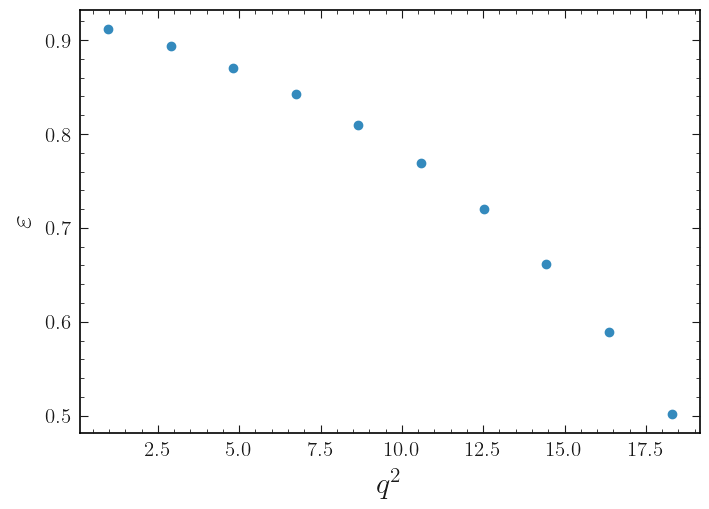

In [99]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

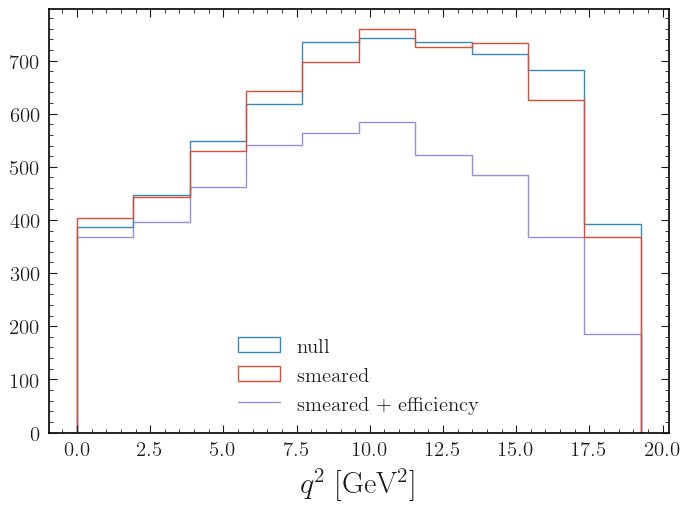

In [100]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [101]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=789))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [102]:
np.random.seed(101)
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

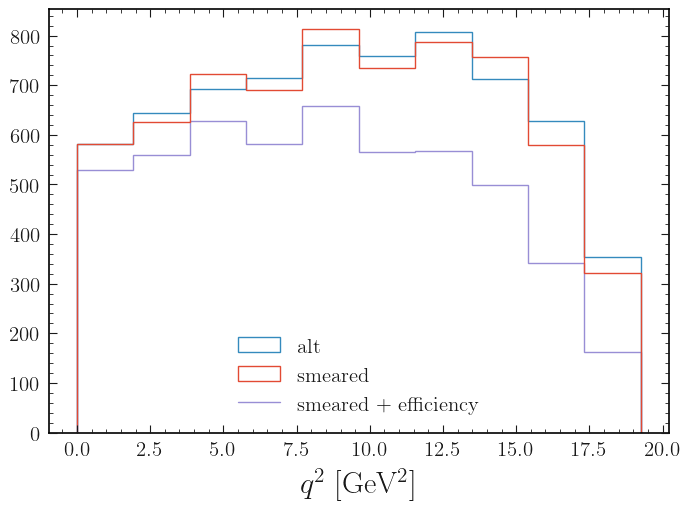

In [103]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Set up the mapping distribution

In [104]:
mapping_dist = modifier.map(null_samples_smeared.flatten(), [null_samples.flatten()], binning, [q2binning])
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [105]:
null = null_pred()
alt = alt_pred()

In [106]:
ana  = analysis()

v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()

a00  = ana.parameters['B->K^*::alpha^A0_0@BSZ2015' ].evaluate() 
a01  = ana.parameters['B->K^*::alpha^A0_1@BSZ2015' ].evaluate() 
a02  = ana.parameters['B->K^*::alpha^A0_2@BSZ2015' ].evaluate()

a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()

a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()

t10  = ana.parameters['B->K^*::alpha^T1_0@BSZ2015' ].evaluate()
t11  = ana.parameters['B->K^*::alpha^T1_1@BSZ2015' ].evaluate()
t12  = ana.parameters['B->K^*::alpha^T1_2@BSZ2015' ].evaluate()

t21  = ana.parameters['B->K^*::alpha^T2_1@BSZ2015' ].evaluate()
t22  = ana.parameters['B->K^*::alpha^T2_2@BSZ2015' ].evaluate()

t230 = ana.parameters['B->K^*::alpha^T23_0@BSZ2015'].evaluate()
t231 = ana.parameters['B->K^*::alpha^T23_1@BSZ2015'].evaluate()
t232 = ana.parameters['B->K^*::alpha^T23_2@BSZ2015'].evaluate()

In [107]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded
Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.026308,0.227334,0.361555,0.016857,0.058229,-0.330734,0.144286,-0.145639,0.009349,0.081273,0.547333,0.015807,-0.018541,-0.393395,0.120207,0.387623,-0.000915,-0.213247,-0.148970
1,0.227334,6.523629,3.907149,-0.092712,0.601056,3.665396,1.914000,-1.285432,-0.200695,-0.188650,3.602537,-0.079337,-1.929198,0.821670,-1.574158,-1.843865,-0.401268,-6.605681,-3.532242
2,0.361555,3.907149,20.628744,0.609721,2.361199,-9.706130,-0.502964,-20.901689,0.667727,3.038829,-10.265474,0.597885,1.979528,1.498004,7.823844,30.671926,0.397703,0.854005,8.513127
3,0.016857,-0.092712,0.609721,0.041382,0.091887,-0.716220,-0.080897,-0.884696,0.048148,0.109509,-0.145938,0.043733,0.103500,-0.509097,0.471181,1.328058,0.048237,0.277517,0.095073
4,0.058229,0.601056,2.361199,0.091887,0.375257,-1.011397,-0.094917,-2.995834,0.105340,0.299731,-1.067580,0.099139,0.167033,-0.427845,1.092137,3.604518,0.078874,0.115279,0.220884
5,-0.330734,3.665396,-9.706130,-0.716220,-1.011397,19.894632,-0.765556,5.177959,-0.645827,-4.441901,-8.231303,-0.624155,-3.557111,10.694118,-7.591892,-23.854362,-0.583141,-4.741560,-7.040107
6,0.144286,1.914000,-0.502964,-0.080897,-0.094917,-0.765556,2.359520,6.577389,-0.234694,0.923369,8.307493,-0.144818,-0.036854,-0.724290,-1.711808,-3.834397,-0.346188,-3.234302,-0.148740
7,-0.145639,-1.285432,-20.901689,-0.884696,-2.995834,5.177959,6.577389,41.666099,-1.372110,0.704900,29.495019,-1.127005,-0.199510,1.790062,-12.476810,-37.786901,-1.419505,-7.250385,-1.057543
8,0.009349,-0.200695,0.667727,0.048148,0.105340,-0.645827,-0.234694,-1.372110,0.066341,0.036734,-0.737097,0.055247,0.101925,-0.465490,0.596763,1.592815,0.073186,0.491713,0.079138
9,0.081273,-0.188650,3.038829,0.109509,0.299731,-4.441901,0.923369,0.704900,0.036734,2.016804,2.628920,0.042362,1.511808,-0.002666,1.180743,5.707718,-0.039411,0.445568,3.884943


In [108]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,), 'bounds': ((3., 9.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'FFKs'    :{'inits': (v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

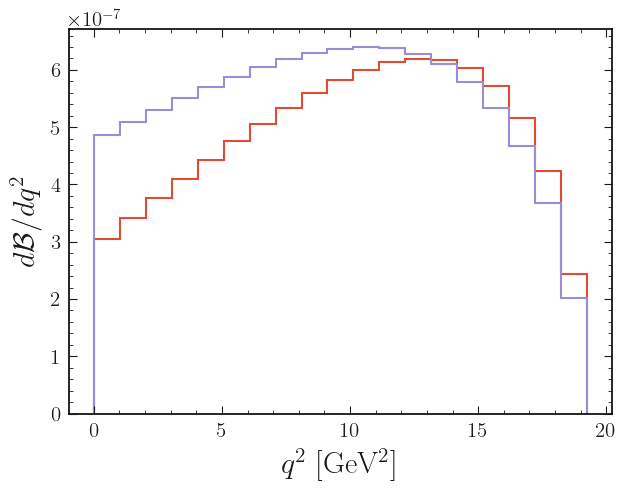

In [109]:
pars = (cvl, cvr, csl, csr, ctl, v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232)
lims = [0.0, 19.25]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

(<Figure size 800x550 with 2 Axes>,
 <Axes: xlabel='Kinematic bins', ylabel='Fitting bins'>)

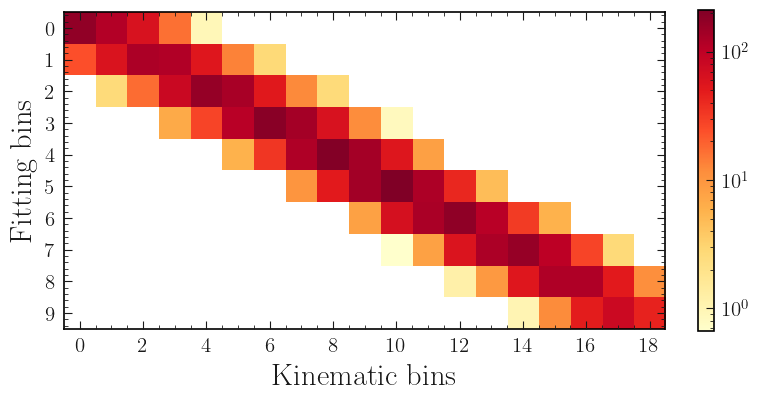

In [110]:
plot.map(cmod, cmap='YlOrRd', norm=LogNorm())

## Set up the model

In [111]:
spec = {
  "channels": [
    {
      "name": "B->K*nunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "ksnunu_theory",
                "type": "ksnunu",
                "data":
                    {"expr": "ksnunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->K*nunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->K*nunu',
   'samples': [{'name': 'signal',
     'data': [368.4145718066182,
      396.5893959353884,
      461.3927398489284,
      541.2532784972486,
      564.4040192173987,
      583.9584922245442,
      522.3069003807129,
      484.5685238581726,
      368.7954386645747,
      184.70364048239557],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [19.194128576380283,
        19.914552365930508,
        21.480054465688127,
        23.264850708681728,
        23.75718879028827,
        24.165233129944024,
        22.854034663067985,
        22.012917204636295,
        19.204047455278136,
        13.590571749650401]},
      {'name': 'ksnunu_theory',
       'type': 'ksnunu',
       'data': {'expr': 'ksnunu_weight_fn'}}]}]}]}

## Save and load model

In [112]:
modifier.save('ksnunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('ksnunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [113]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
# fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.0339926
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W MnPosDef Matrix forced pos-def by adding to diagonal 0.7113
W MnPosDef Matrix forced pos-def by adding to diagonal 0.119525


{'cvl': array([8.02169418, 0.1650926 ]),
 'cvr': array([0.24225562, 0.31064492]),
 'csl': array([0.01005883, 4.10506909]),
 'csr': array([0.01, 0.  ]),
 'ctl': array([0.00656166, 5.73836458]),
 'FFKs_decorrelated[0]': array([-0.19794309,  0.09216162]),
 'FFKs_decorrelated[1]': array([-0.03015864,  0.02246622]),
 'FFKs_decorrelated[2]': array([0.11035119, 0.2277794 ]),
 'FFKs_decorrelated[3]': array([0.08541108, 0.0259691 ]),
 'FFKs_decorrelated[4]': array([-0.01081139,  0.18229076]),
 'FFKs_decorrelated[5]': array([-0.08715503,  0.04571362]),
 'FFKs_decorrelated[6]': array([0.02376022, 0.29508094]),
 'FFKs_decorrelated[7]': array([0.01449308, 0.15525998]),
 'FFKs_decorrelated[8]': array([0.02037789, 0.13356789]),
 'FFKs_decorrelated[9]': array([-0.03332619,  0.15311623]),
 'FFKs_decorrelated[10]': array([-0.00424148,  0.38141948]),
 'FFKs_decorrelated[11]': array([0.00920953, 0.54156934]),
 'FFKs_decorrelated[12]': array([0.00194784, 0.82491068]),
 'FFKs_decorrelated[13]': array([-0.00

In [114]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 8.021694178901317,
 'cvr': 0.24225562090353314,
 'csl': 0.010058829633803043,
 'csr': 0.01,
 'ctl': 0.006561656823539158,
 'FFKs[0]': 0.3527597713265532,
 'FFKs[1]': -1.459690715825376,
 'FFKs[2]': 3.4038237450816693,
 'FFKs[3]': 0.3724310115750893,
 'FFKs[4]': -1.0967856714545217,
 'FFKs[5]': 1.6389587844417322,
 'FFKs[6]': 0.09293692186453756,
 'FFKs[7]': -0.3146664216717353,
 'FFKs[8]': 1.264363406643833,
 'FFKs[9]': 0.7599069360256744,
 'FFKs[10]': -0.17504900836573345,
 'FFKs[11]': 0.3467050723969712,
 'FFKs[12]': -0.6885844537782191,
 'FFKs[13]': 2.2090146435985294,
 'FFKs[14]': 1.047164203670067,
 'FFKs[15]': 3.255616289483073,
 'FFKs[16]': 0.6650027068854428,
 'FFKs[17]': 1.548199712855941,
 'FFKs[18]': 2.603084425718465,
 'mu': 1.0,
 'stat': [0.9755143783624269,
  1.0177294452619454,
  1.0471800728177407,
  0.9523049445642082,
  1.023050193973934,
  0.9476379310276123,
  1.0261572072163363,
  1.0211715518547233,
  0.9910963032448491,
  0.9882570187735346]}

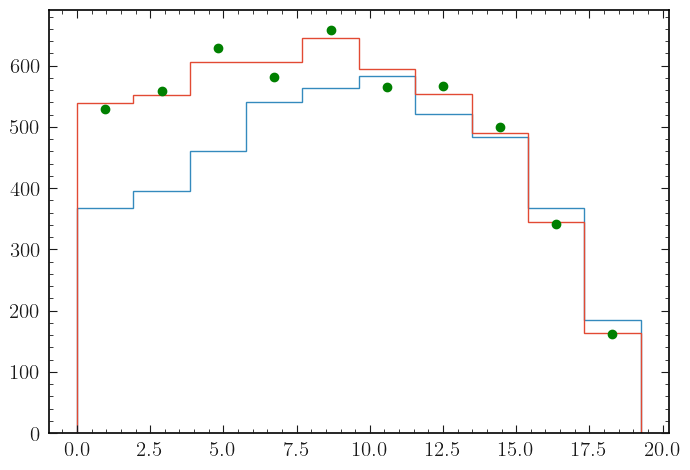

In [115]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')

In [116]:
SMBR

9.339622386594036e-06